In [1]:
# Copyright (c) Meta Platforms, Inc. and affiliates.

# Segment Anything Model 

The first half of this notebook is taken from the Meta Tutorial Notebook (https://github.com/facebookresearch/segment-anything/blob/main/notebooks/automatic_mask_generator_example.ipynb). This is a good introduction on how to use SAM to generate masks over images. The second half of this notebook will be applying it to materials informatics. 

## Automatically generating object masks with SAM

Since SAM can efficiently process prompts, masks for the entire image can be generated by sampling a large number of prompts over an image. This method was used to generate the dataset SA-1B. 

The class `SamAutomaticMaskGenerator` implements this capability. It works by sampling single-point input prompts in a grid over the image, from each of which SAM can predict multiple masks. Then, masks are filtered for quality and deduplicated using non-maximal suppression. Additional options allow for further improvement of mask quality and quantity, such as running prediction on multiple crops of the image or postprocessing masks to remove small disconnected regions and holes.

In [2]:
from IPython.display import display, HTML
display(HTML(
"""
<a target="_blank" href="https://colab.research.google.com/github/facebookresearch/segment-anything/blob/main/notebooks/automatic_mask_generator_example.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>
"""
))

### Environment Set-up

If running locally using jupyter, first install `segment_anything` in your environment using the [installation instructions](https://github.com/facebookresearch/segment-anything#installation) in the repository. If running from Google Colab, set `using_colab=True` below and run the cell. In Colab, be sure to select 'GPU' under 'Edit'->'Notebook Settings'->'Hardware accelerator'.

In [3]:
using_colab = False

In [4]:
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'
    
    !mkdir images
    !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/dog.jpg
        
    !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

### Set-up

In [5]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
import torchvision 

In [6]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

### Example image

In [7]:
image = cv2.imread('dog.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

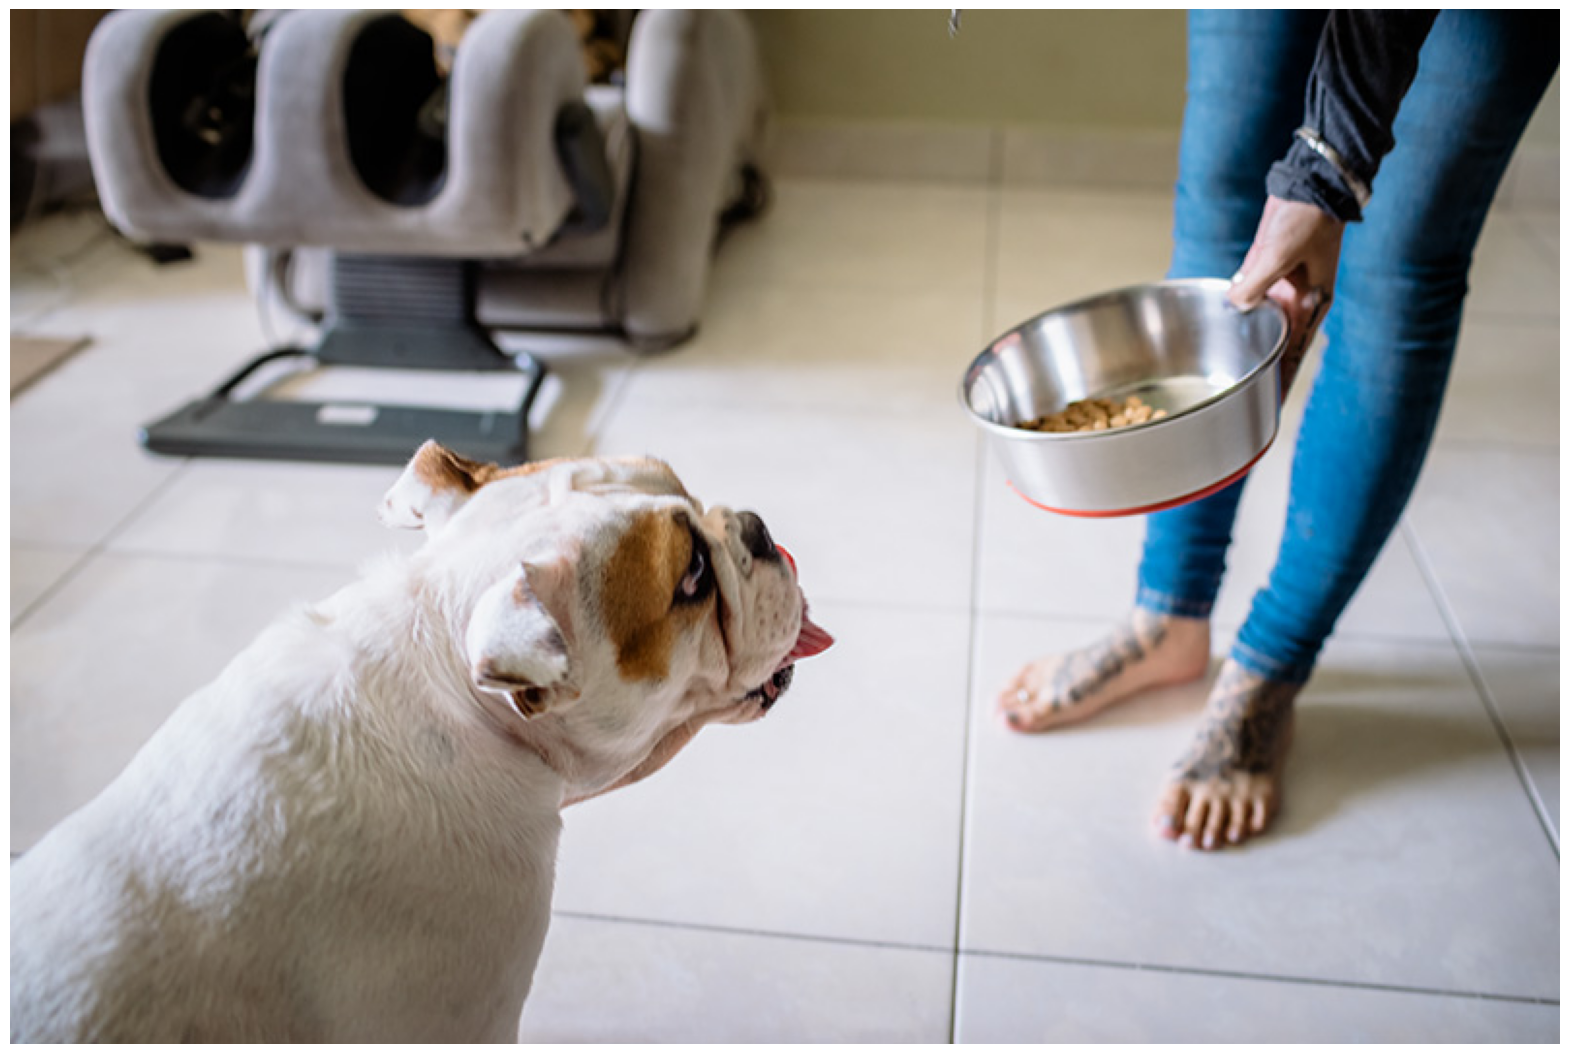

In [8]:
plt.figure(figsize=(20,20))
plt.imshow(image)
plt.axis('off')
plt.show()

### Automatic mask generation

To run automatic mask generation, provide a SAM model to the `SamAutomaticMaskGenerator` class. Set the path below to the SAM checkpoint. Running on CUDA and with the default model is recommended.

In [9]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

# device = "cuda"
device = "cpu"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

/opt/miniconda3/envs/sam/lib/python3.11/site-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


To generate masks, just run `generate` on an image.

In [10]:
masks = mask_generator.generate(image)

Mask generation returns a list over masks, where each mask is a dictionary containing various data about the mask. These keys are:
* `segmentation` : the mask
* `area` : the area of the mask in pixels
* `bbox` : the boundary box of the mask in XYWH format
* `predicted_iou` : the model's own prediction for the quality of the mask
* `point_coords` : the sampled input point that generated this mask
* `stability_score` : an additional measure of mask quality
* `crop_box` : the crop of the image used to generate this mask in XYWH format

In [11]:
print(len(masks))
print(masks[0].keys())

66
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


Show all the masks overlayed on the image.

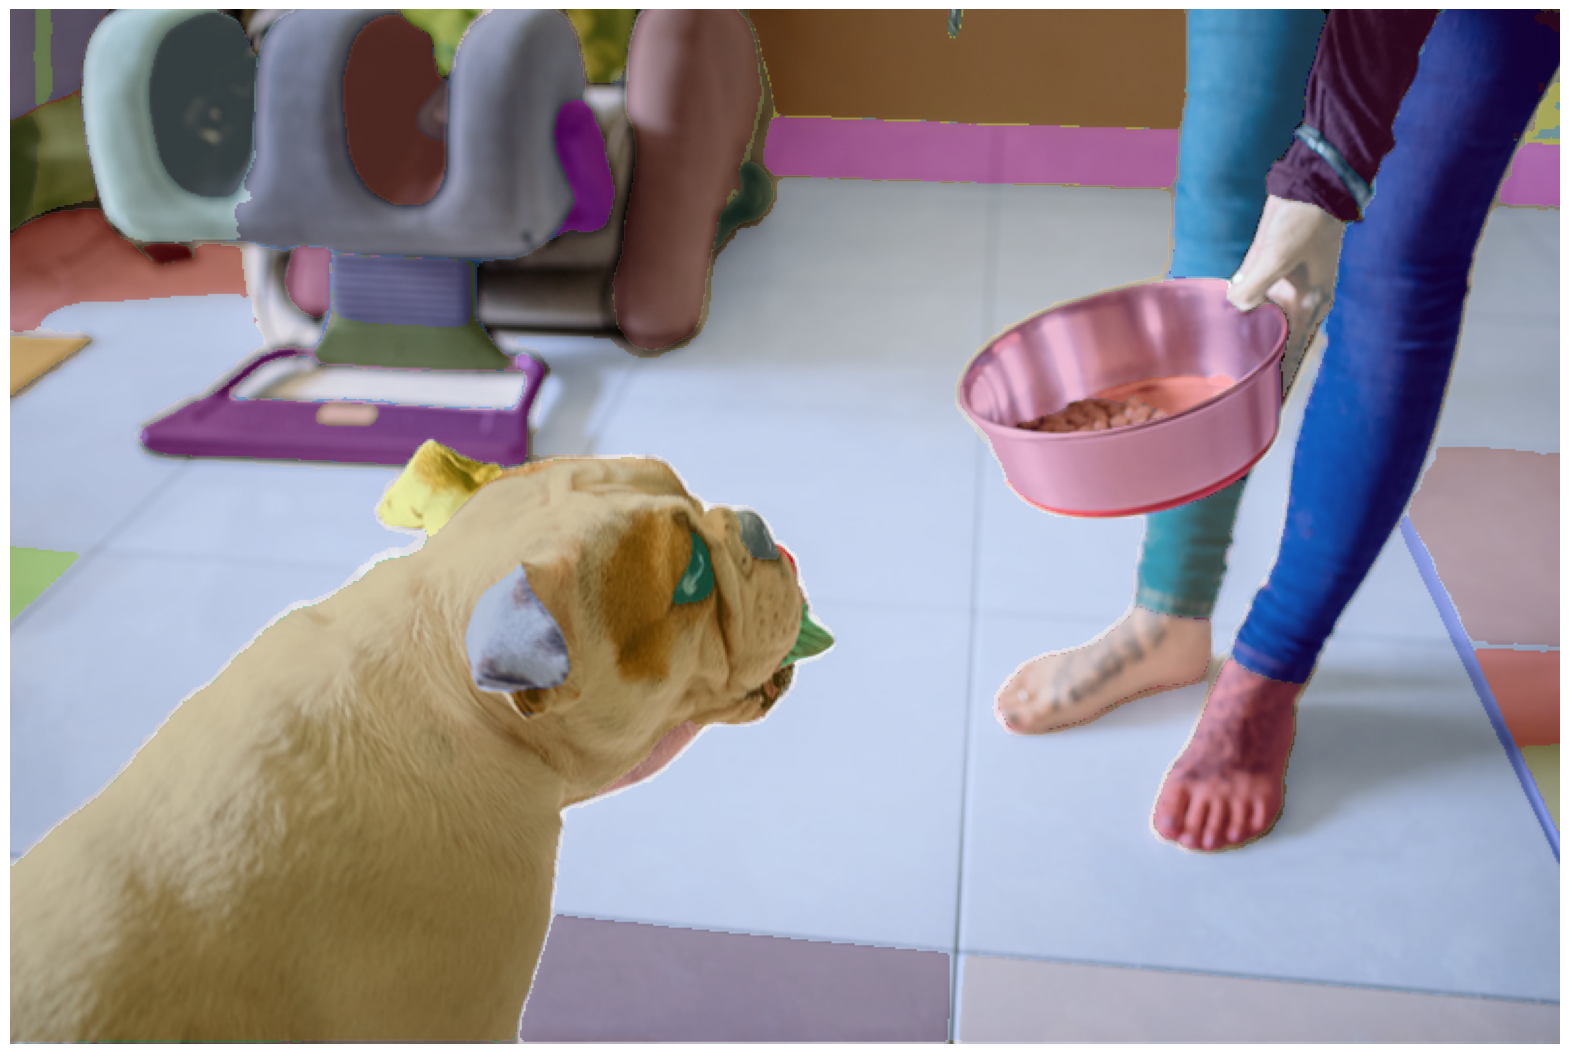

In [12]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show() 

### Automatic mask generation options

There are several tunable parameters in automatic mask generation that control how densely points are sampled and what the thresholds are for removing low quality or duplicate masks. Additionally, generation can be automatically run on crops of the image to get improved performance on smaller objects, and post-processing can remove stray pixels and holes. Here is an example configuration that samples more masks:

In [13]:
mask_generator_2 = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=0.86,
    stability_score_thresh=0.92,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100,  # Requires open-cv to run post-processing
)

In [14]:
masks2 = mask_generator_2.generate(image)

In [15]:
len(masks2)

90

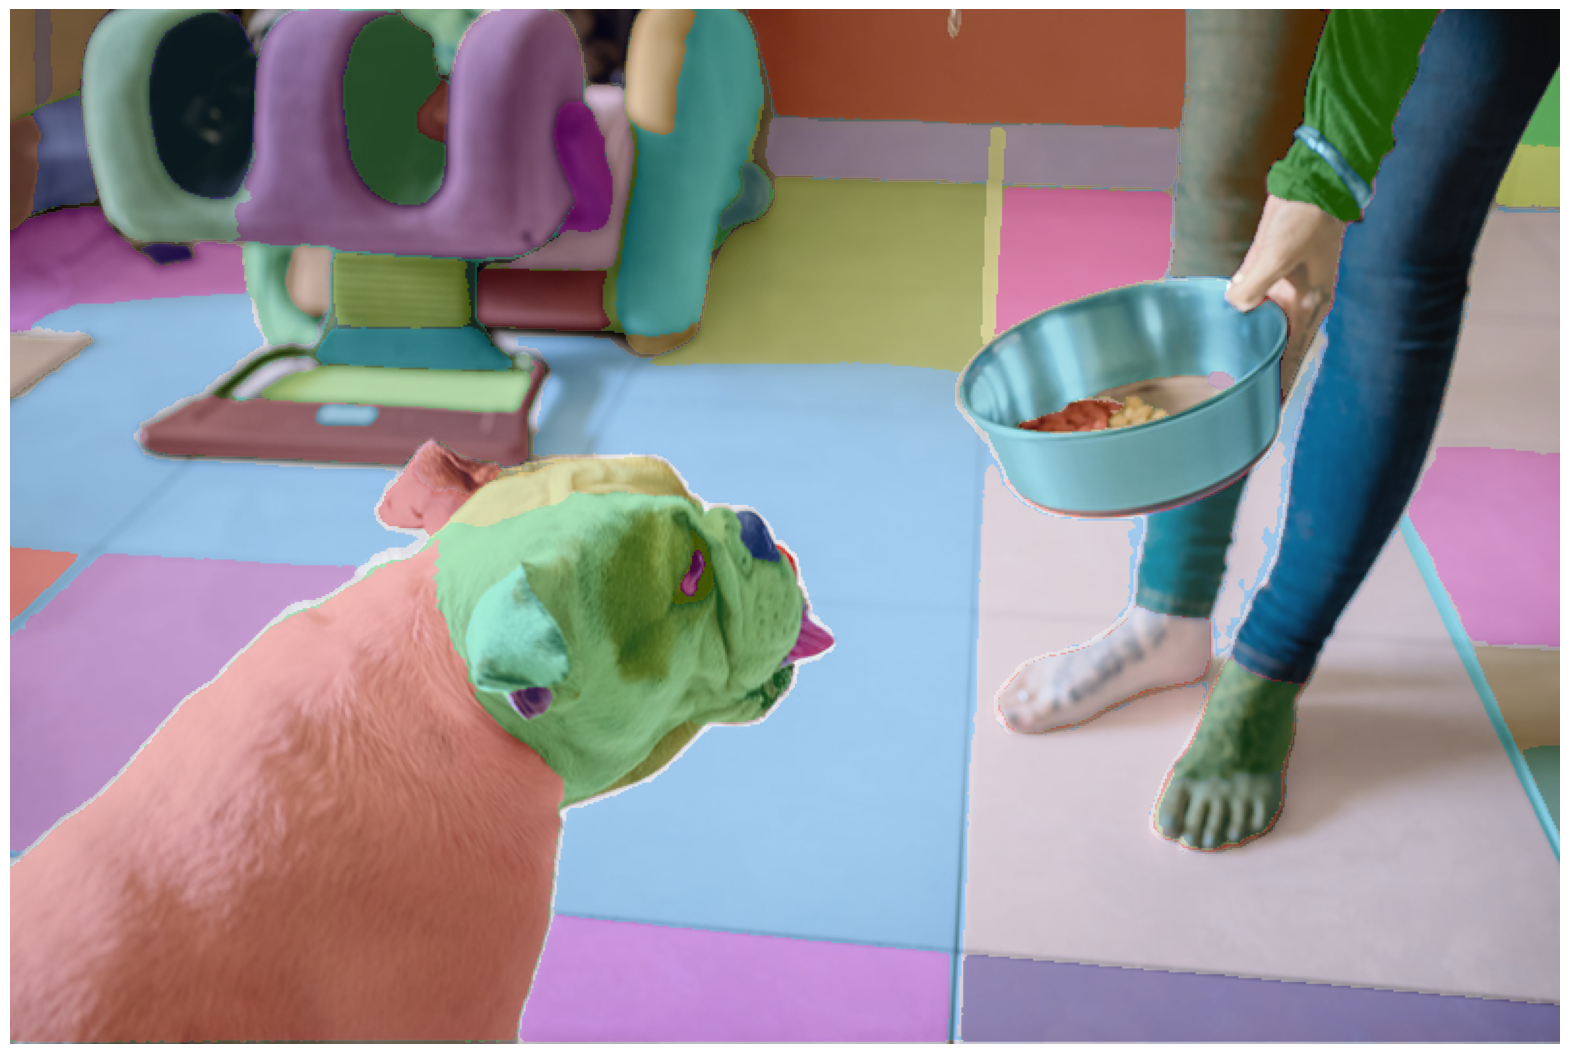

In [16]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks2)
plt.axis('off')
plt.show() 

Try with microstructures

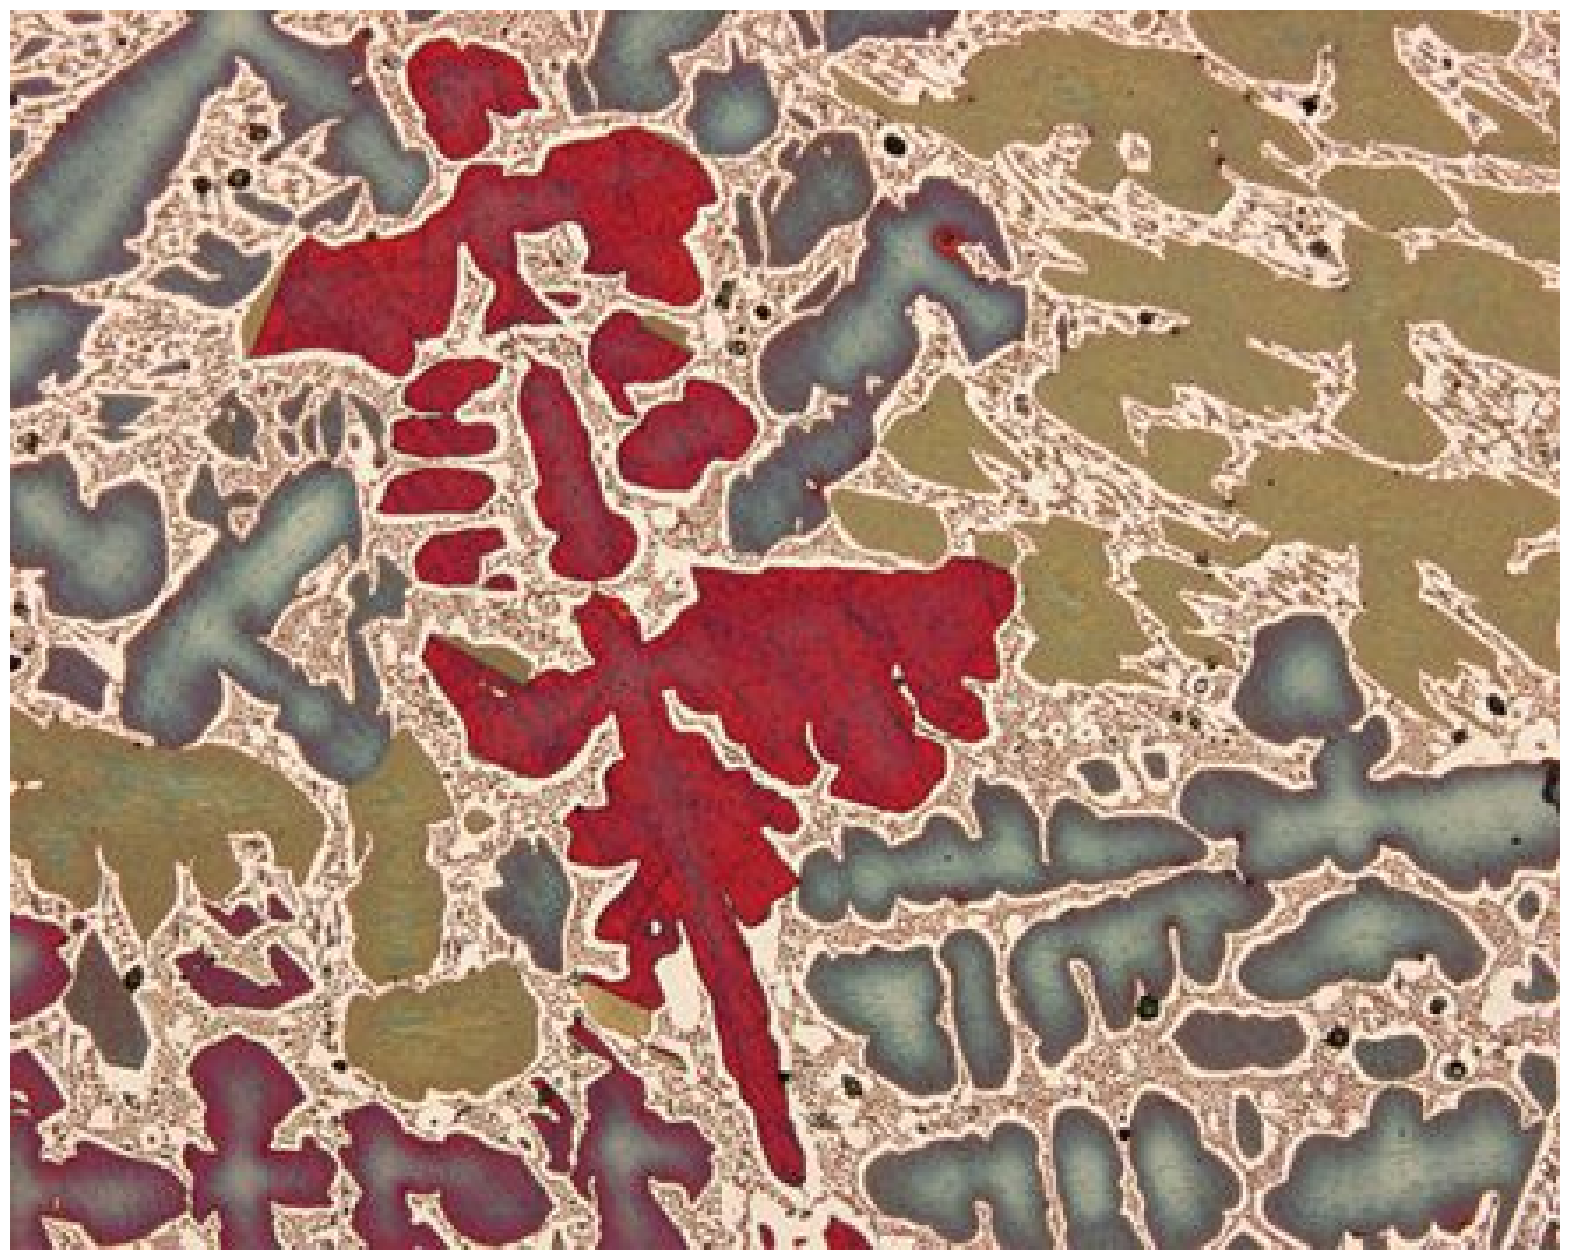

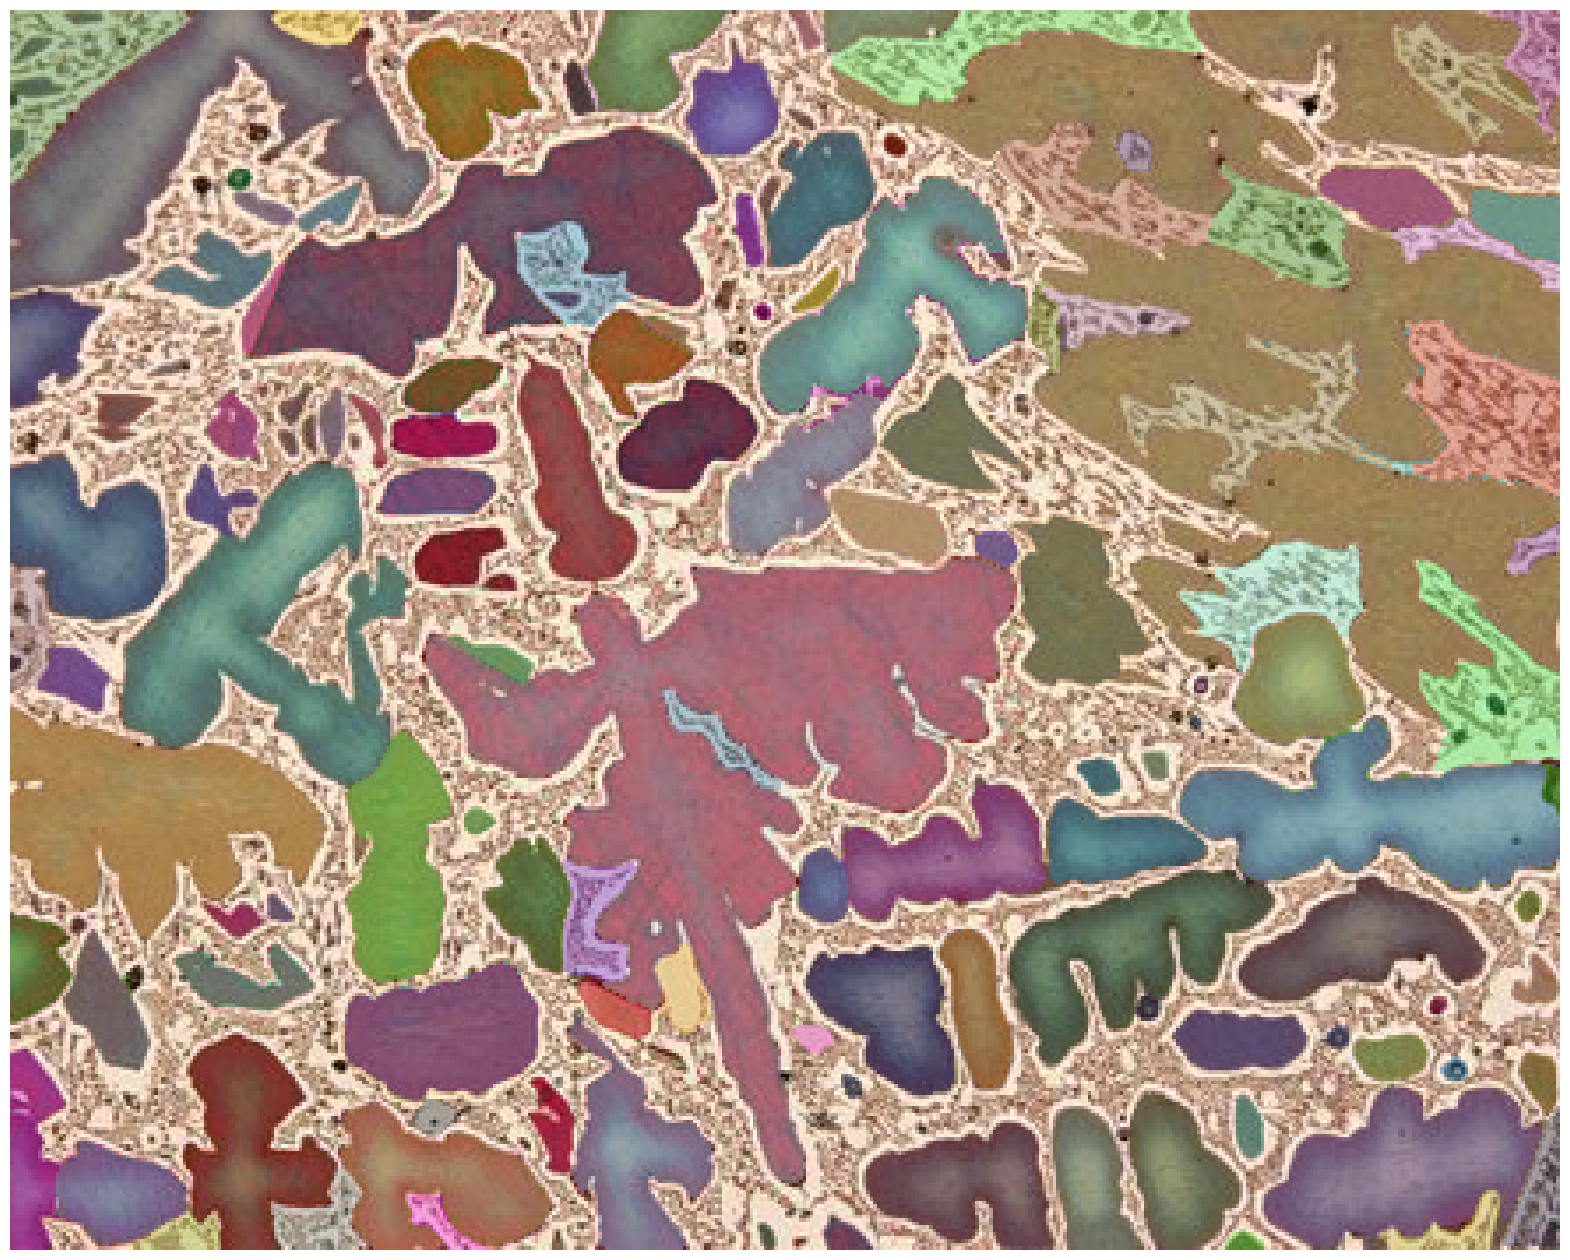

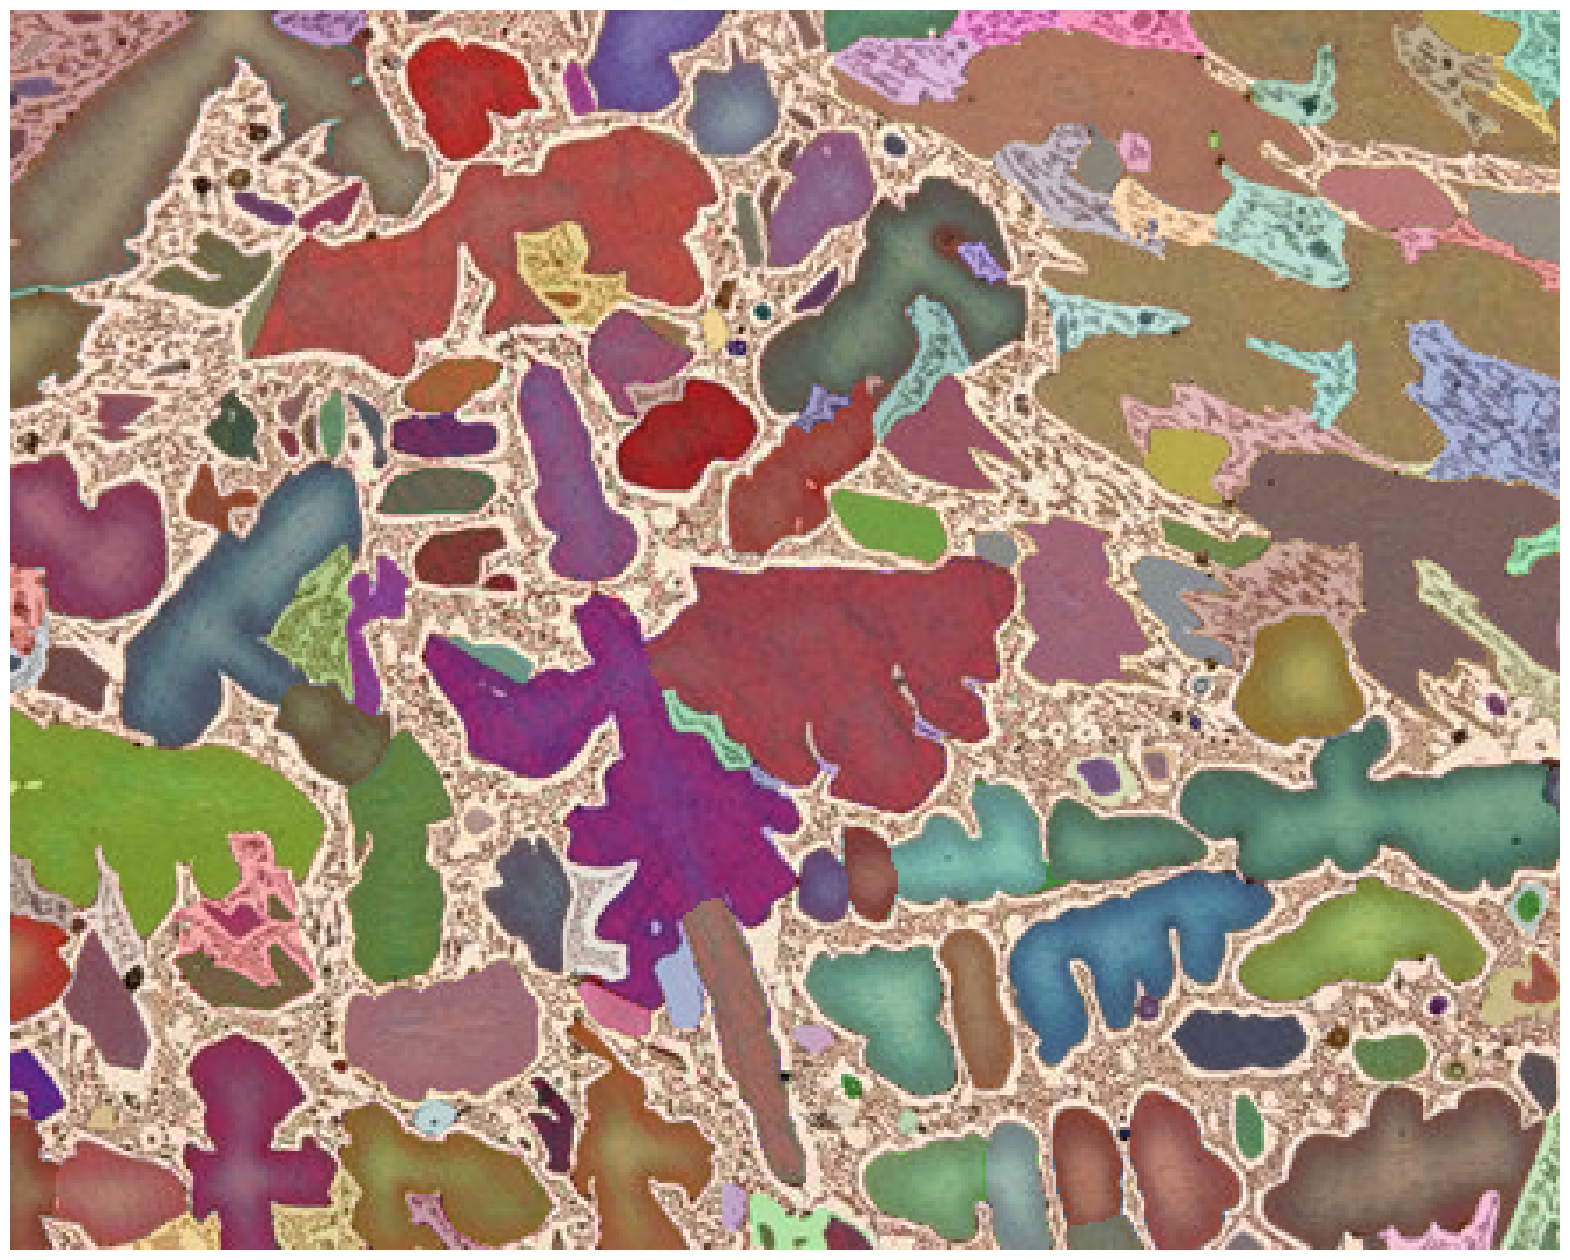

0.00962035123966942
0.006876291322314049
0.007864152892561984
0.0032993285123966943
0.004984504132231405
0.004713326446280992
0.005242768595041323
0.002253357438016529
0.001846590909090909
0.004422778925619835
0.0017884814049586777
0.0028021694214876033
0.0011492768595041322
0.0017884814049586777
0.0014010847107438016
0.026794938016528925
0.0034672004132231403
0.0036867252066115704
0.002363119834710744
0.0009168388429752066
0.0063339359504132236
0.0007166838842975207
0.0007425103305785124
0.0016076962809917356
0.0007489669421487604
0.0038868801652892563
0.0011363636363636363
0.007773760330578513
0.009872159090909091
0.003802944214876033
0.003202479338842975
0.002537448347107438
0.010020661157024793
0.001181559917355372
0.00853564049586777
0.0015302169421487603
0.009413739669421488
0.01903409090909091
0.0024793388429752068
0.002350206611570248
0.0012267561983471075
0.008716425619834711
0.0008651859504132231
0.0015237603305785124
0.0017239152892561983
0.0029700413223140497
0.001304235537

In [18]:
image = cv2.imread('microstructure1.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(20,20))
plt.imshow(image)
plt.axis('off')
plt.show()

masks = mask_generator.generate(image)

plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show()

masks2 = mask_generator_2.generate(image)

plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks2)
plt.axis('off')
plt.show()

# print the percent area of each mask in the image
total_area = image.shape[0] * image.shape[1]

for mask in masks2:
    mask_area = mask['area']
    print(mask_area / total_area)

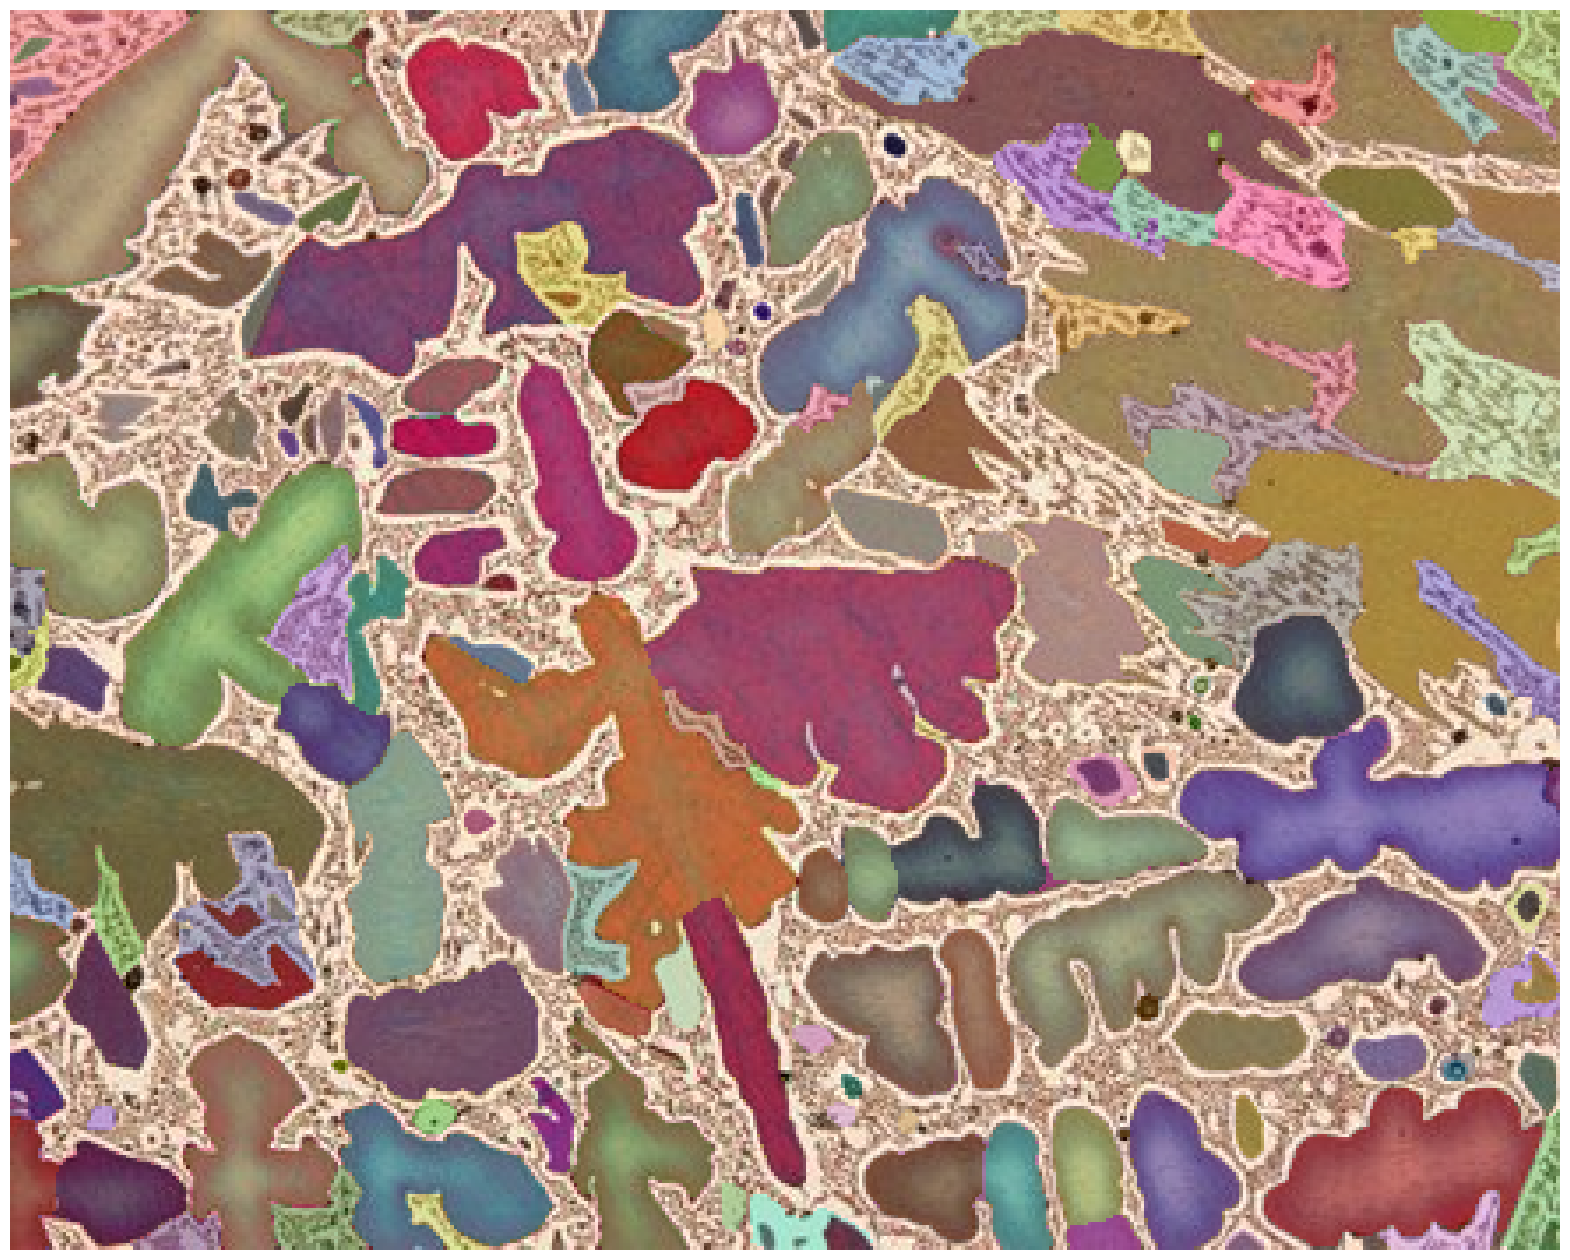

In [19]:
# create masks over the image again but tune them to fit the large dendrite formations
mask_generator_3 = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=0.86,
    stability_score_thresh=0.92,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100,  # Requires open-cv to run post-processing
)

masks3 = mask_generator_3.generate(image)

plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks3)
plt.axis('off')
plt.show()

In [20]:
# print how many masks there are 

print(len(masks3))
print(masks3[0].keys())

198
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


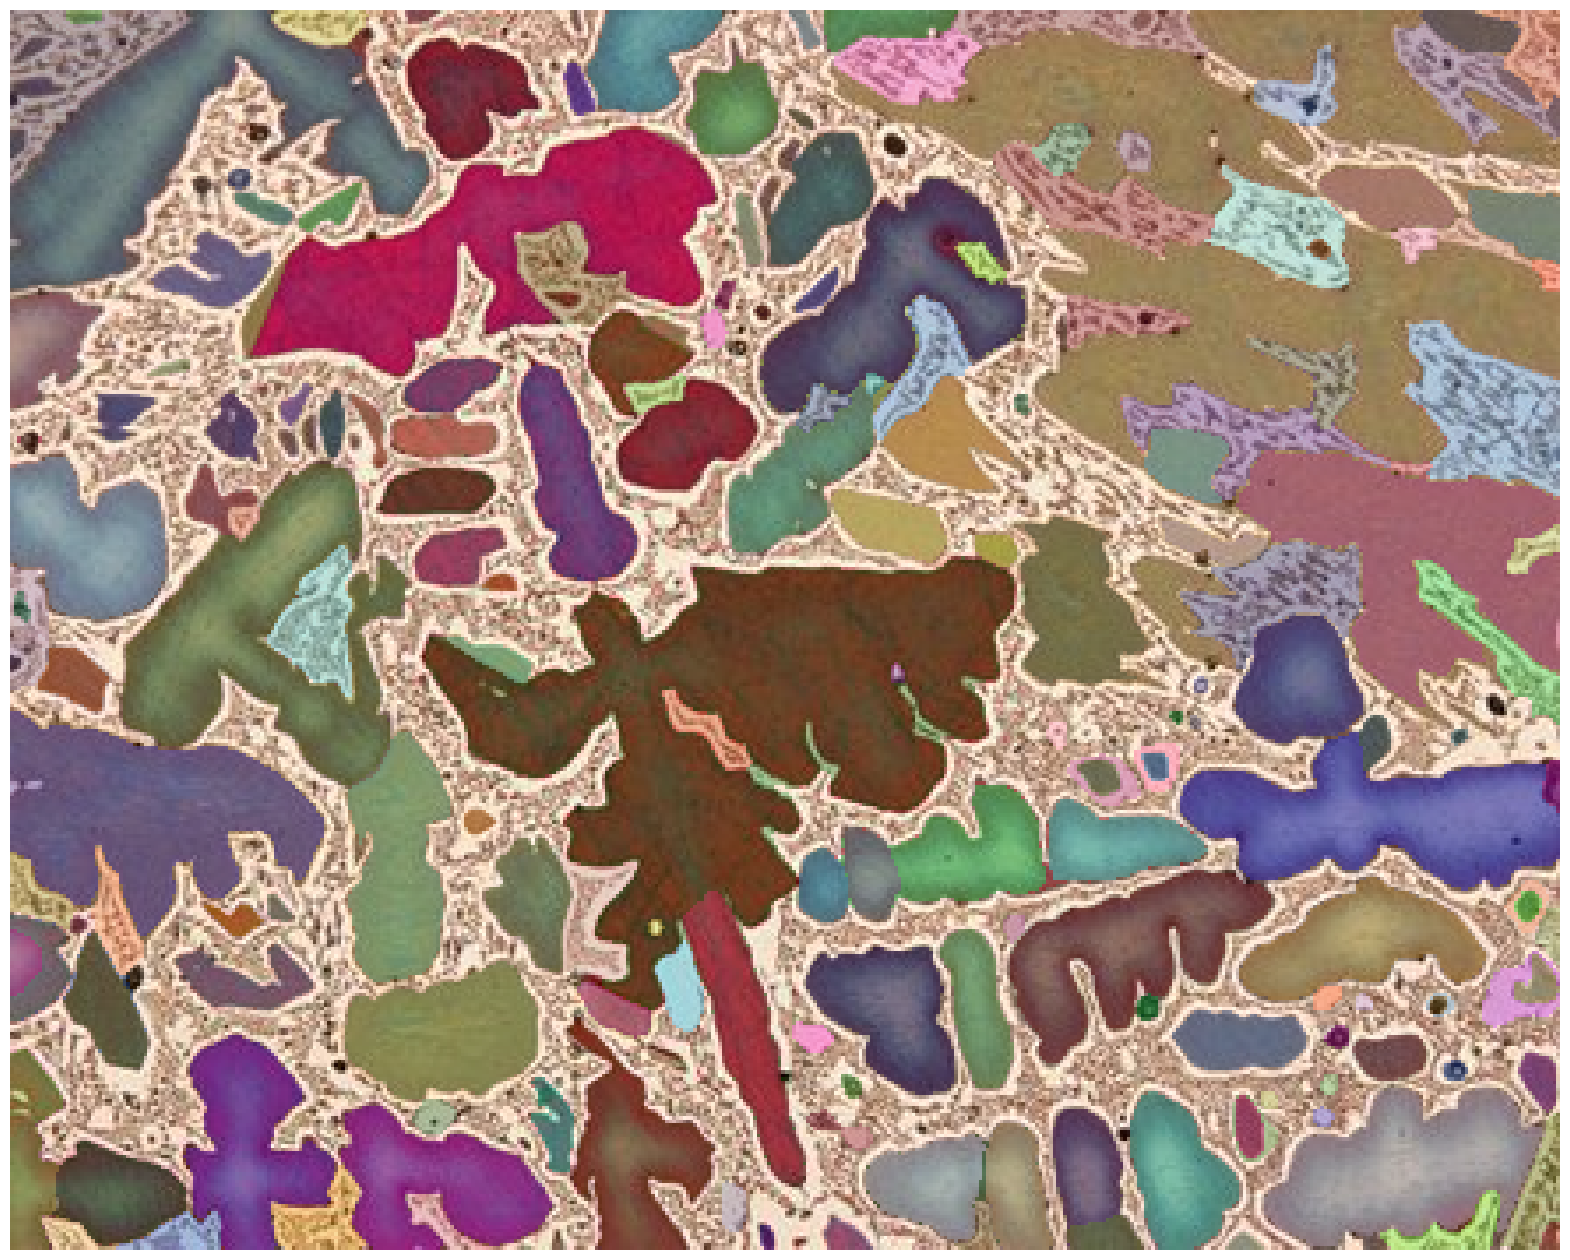

In [21]:
# create masks over the image again but tune them to fit the large dendrite formations
mask_generator_3 = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=0.9,
    stability_score_thresh=0.95,
    crop_n_layers=1,
    crop_n_points_downscale_factor=1,
    min_mask_region_area=10000,  # Requires open-cv to run post-processing
)

masks3 = mask_generator_3.generate(image)

plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks3)
plt.axis('off')
plt.show()

In [22]:
# print how many masks there are

print(len(masks3))

194
